### Introduction


Situated in the Pacific Northwest region of the United States, Olympic National Park is a magnificent display of nature’s splendor and variety. This vast wilderness, located in Washington state, spans from the rugged coastline to the verdant temperate rainforests and impressive mountain peaks.

Covering close to a million acres, Olympic National Park is celebrated for its ecological diversity and distinctive landscapes. The park extends from the dramatic sea stacks and tide pools of the Pacific coastline to the verdant Hoh Rainforest, one of the world’s few temperate rainforests. Further inland, the park is characterized by the awe-inspiring Olympic Mountains, with Mount Olympus standing as the range’s tallest peak.

The park’s varied ecosystems are home to a rich array of wildlife, including Roosevelt elk, black bears, mountain goats, and numerous bird species. Visitors to Olympic National Park have the opportunity to traverse its extensive network of hiking trails, which vary from leisurely walks to demanding backcountry expeditions, providing chances to experience the untouched beauty of nature.






#### Importing necessary libraries

In [19]:
# dataset download
import io, requests, zipfile

# dataframes
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

# rasters
import rasterio as rst
from rasterio.plot import show
from rasterio.mask import mask

# plot and graphs
import matplotlib.pyplot as plt
from matplotlib import cm, colors

# ignore warning about missing/empty geometries
import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# earth engine visualizations
import geemap
import ee
# for dependencies
%matplotlib inline

#### Washington state administrative boundaries

In [3]:
# Washington state Administrative boundries
wsh_boundaries = gpd.read_file('Boundries/USA_AL4_Washington.json')
wsh_boundaries  = wsh_boundaries[['name', 'geometry']]

In [4]:
wsh_boundaries.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   name      1 non-null      object  
 1   geometry  1 non-null      geometry
dtypes: geometry(1), object(1)
memory usage: 144.0+ bytes


In [5]:
def set_map_limits(min_x,min_y,max_x,max_y):
  """
  Sets map's axis ranges.
  """
  plt.xlim(min_x, max_x)
  plt.ylim(min_y,max_y)

In [11]:
def plot_state(df,ax):
  """
  Plots states' borders on the map.
  """
  df.plot(ax=ax, color='silver', edgecolor='black')

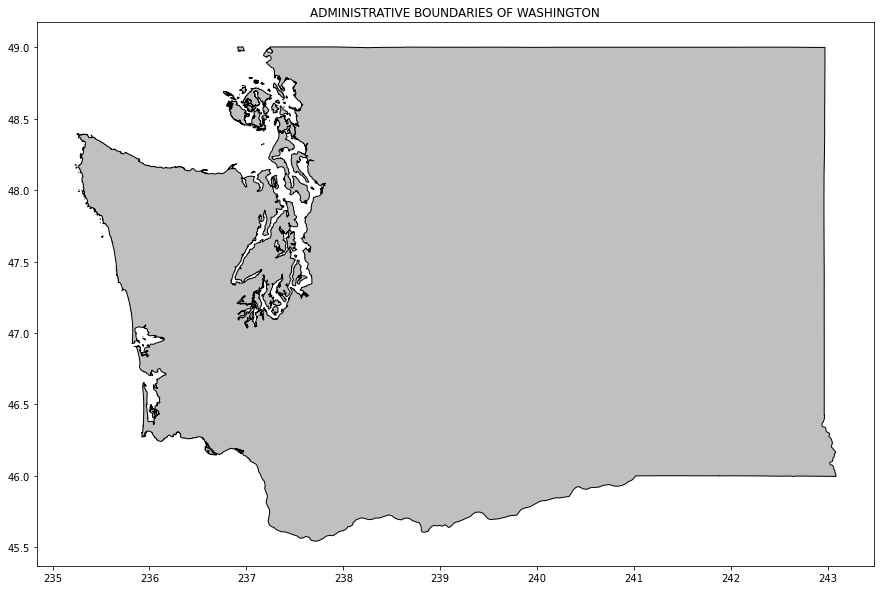

In [12]:
# visualize coutries' borders
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title('ADMINISTRATIVE BOUNDARIES OF WASHINGTON')
plot_state(wsh_boundaries,ax)

plt.show()

In [13]:
wsh_boundaries.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Olympic National Park on the map

In [55]:
# get geometry and other useful information of the ecoregion
park_df_original = gpd.read_file("Boundries/NPS_Land_Resources_Division_Boundary_and_Tract_Data_Service_-5040056028728048782.geojson")


In [56]:
park_df_original = park_df_original[park_df_original["UNIT_NAME"] == "Olympic National Park"]

In [57]:
park_df_original.head()

,OBJECTID,CreationDate,Creator,EditDate,Editor,GlobalID,AreaID,UNIT_CODE,GIS_Notes,UNIT_NAME,DATE_EDIT,STATE,REGION,GNIS_ID,UNIT_TYPE,CREATED_BY,METADATA,PARKNAME,geometry
374,376,"Mon, 08 Jan 2024 14:09:23 GMT",NPS_WASO_LANDS,"Mon, 08 Jan 2024 14:09:23 GMT",NPS_WASO_LANDS,26a2a011-3e02-4fa1-9739-7965e039bdf7,395,OLYM,Unofficial Boundary of Olympic National Park.,Olympic National Park,"Wed, 22 Apr 2015 00:00:00 GMT",WA,PW,1530459,National Park,Legacy,Preliminary data. Contact the Land Resources P...,Olympic,"MULTIPOLYGON (((-13845943.772 6040940.403, -13..."


In [58]:
park_df_original = park_df_original.to_crs("EPSG:4326")

In [59]:
def plot_park(df,ax, color='#8CFA7D', edgecolor='#0C5D01', linewidth=1):
  """
  Plots forest's boundaries on the map.
  """
  df.plot(ax=ax, color=color, edgecolor=edgecolor, linewidth=linewidth)

In [60]:
def add_360_to_first_coordinate(multipolygon):
    new_polygons = []
    for polygon in multipolygon.geoms:
        new_exterior_coords = list(polygon.exterior.coords)
        for i in range(len(new_exterior_coords)) :
            new_exterior_coords[i] = (new_exterior_coords[i][0] + 360, new_exterior_coords[i][1])
        new_polygon = Polygon(new_exterior_coords)
        new_polygons.append(new_polygon)
    return MultiPolygon(new_polygons)


In [61]:
park_df_new = park_df_original.copy()
park_df_new["geometry"] = park_df_new["geometry"].apply(add_360_to_first_coordinate)

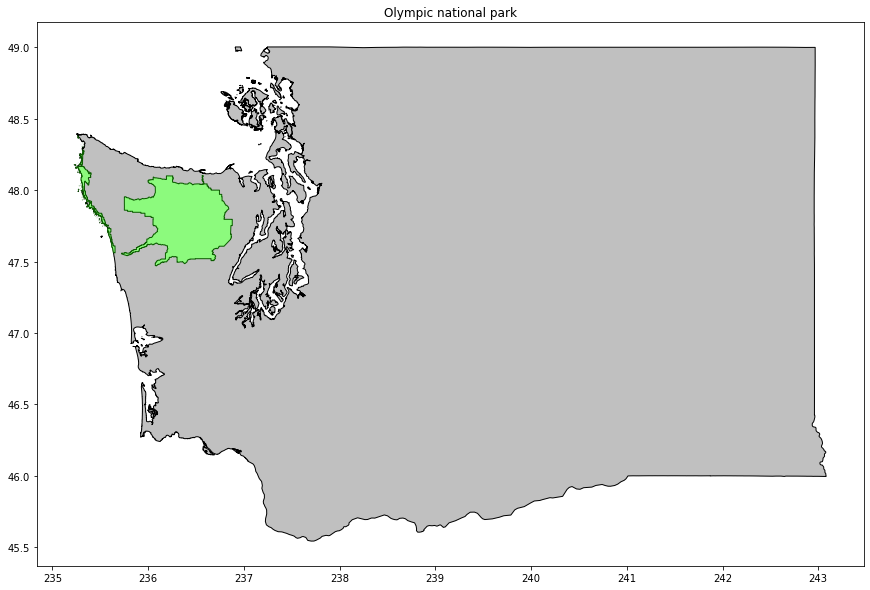

In [62]:
# visualize the park on the map
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Olympic national park')
# set_map_limits()
plot_state(wsh_boundaries,ax)
plot_park(park_df_new,ax)

plt.show()

#### Climate Zones

In [63]:
# download climate data
climate_df = gpd.read_file("Climate/IPCC_ClimateZoneMap_Vector.geojson")

In [64]:
climate_classification = {
    '1': 'Warm Temperate Moist', 
    '2': 'Warm Temperate Dry', 
    '3': 'Cool Temperate Moist', 
    '4': 'Cool Temperate Dry', 
    '5': 'Polar Moist', 
    '6': 'Polar Dry',
    '7': 'Boreal Moist', 
    '8': 'Boreal Dry',
    '9': 'Tropical Montane', 
    '10': 'Tropical Wet', 
    '11': 'Tropical Dry', 
    '12': 'Tropical Montane Wet', 
    '13': 'Tropical Montane Dry'
}

# normalize column's name
climate_df.rename(columns={'CLASS_NAME': 'class_name'}, inplace=True)

In [65]:
# remove oceans
climate_df = climate_df[climate_df.class_name != 0]

# replace classification codes with actual names
climate_df.class_name = climate_df.class_name.astype('str').replace(climate_classification)


In [66]:
def plot_features(features_df, ax, column, cmap='Set3'):
  """
  Plots some of the park's features on the map.
  """
  features_df.plot(ax=ax, cmap=cmap, column=column, legend=True)

In [67]:
park_df_original

,OBJECTID,CreationDate,Creator,EditDate,Editor,GlobalID,AreaID,UNIT_CODE,GIS_Notes,UNIT_NAME,DATE_EDIT,STATE,REGION,GNIS_ID,UNIT_TYPE,CREATED_BY,METADATA,PARKNAME,geometry
374,376,"Mon, 08 Jan 2024 14:09:23 GMT",NPS_WASO_LANDS,"Mon, 08 Jan 2024 14:09:23 GMT",NPS_WASO_LANDS,26a2a011-3e02-4fa1-9739-7965e039bdf7,395,OLYM,Unofficial Boundary of Olympic National Park.,Olympic National Park,"Wed, 22 Apr 2015 00:00:00 GMT",WA,PW,1530459,National Park,Legacy,Preliminary data. Contact the Land Resources P...,Olympic,"MULTIPOLYGON (((-124.38023 47.60227, -124.3802..."


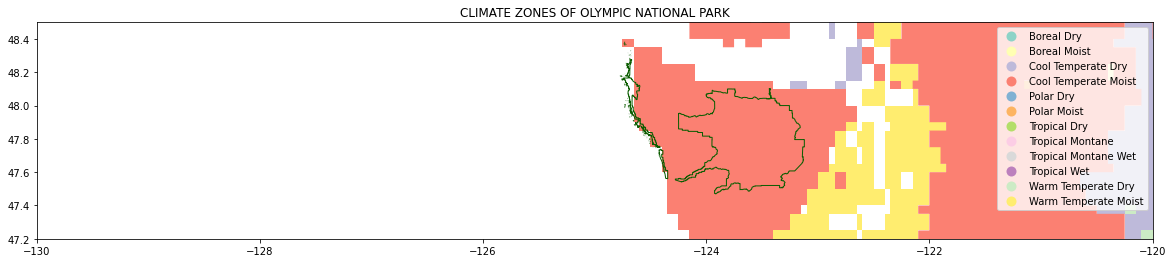

In [68]:
# visualize climate zones on the map
fig, ax = plt.subplots(figsize=(20, 10))
set_map_limits(-130,47.2,-120,48.5)
ax.set_title('CLIMATE ZONES OF OLYMPIC NATIONAL PARK')

plot_features(climate_df, ax=ax, column='class_name')
plot_state(wsh_boundaries,ax)
plot_park(park_df_original,ax=ax,color = 'none')

plt.show()

Hence, Olympic national park has Cool Temperate Moist climate.

#### Global Ecological Zones

In [69]:
gez = gpd.read_file("GEZ/USA_AL4_Washington_GEZ.json")

In [70]:
gez.head()

,country,ISO3166_2,name,gez_name,gez_code,gez_abbrev,adminlevel,geometry
0,USA,US-WA,Washington,Temperate desert,34,TeBWk,4,"POLYGON ((240.34582 49.00011, 240.30941 49.000..."
1,USA,US-WA,Washington,Temperate mountain system,35,TeM,4,"MULTIPOLYGON (((237.14907 46.00174, 237.14375 ..."
2,USA,US-WA,Washington,Temperate oceanic forest,31,TeDo,4,"MULTIPOLYGON (((237.28436 47.09520, 237.28442 ..."


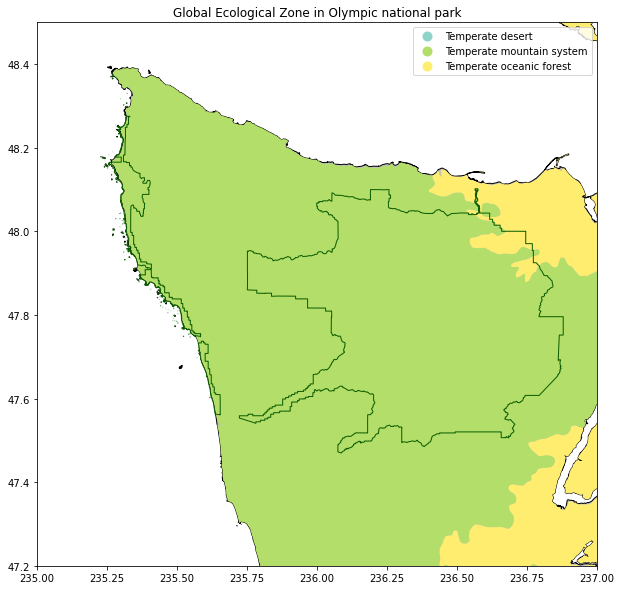

In [73]:
# visualize climate zones on the map
fig, ax = plt.subplots(figsize=(20, 10))
set_map_limits(235,47.2,237,48.5)
ax.set_title('Global Ecological Zone in Olympic national park')

plot_state(wsh_boundaries,ax)
plot_features(gez, ax=ax, column='gez_name')
plot_park(park_df_new,ax=ax,color = 'none')

plt.show()

Hence , Olympic national park largely has Temperate Mountain system along with some Temperate oceanic forest

#### Agro-ecological Zones in Olympic national park

In [74]:
# download agro-ecological zones data
agroeco_zones_df = gpd.read_file("AgroEcoZones/GlobalAgroEcologicalZones_GAEZ.geojson")

In [75]:
values = {'1': 'Steep terrain', '2': 'Artic/Cold', '3': 'Desert/Arid', 
          '4': 'Irrigated Soils', '5': 'Hydromorphic soils', 
          '6': 'Dry, good soils', '7': 'Dry, moderate soils', '8': 'Dry, poor soils', 
          '9': 'Moist, good soils', '10': 'Moist, moderate soils', 
          '11': 'Moist, poor soils', '12': 'Sub-humid, good soils', 
          '13': 'Sub-humid, moderate soils', '14': 'Sub-humid, poor soils', 
          '15': 'Humid, good soils', '16': 'Humid, moderate soils', 
          '17': 'Humid, poor soils', '18': 'Water'}

# normalize column's name
agroeco_zones_df.rename(columns={'Value': 'value'}, inplace=True)

# replace classification codes with actual names
agroeco_zones_df.value = agroeco_zones_df.value.astype('str').replace(values)

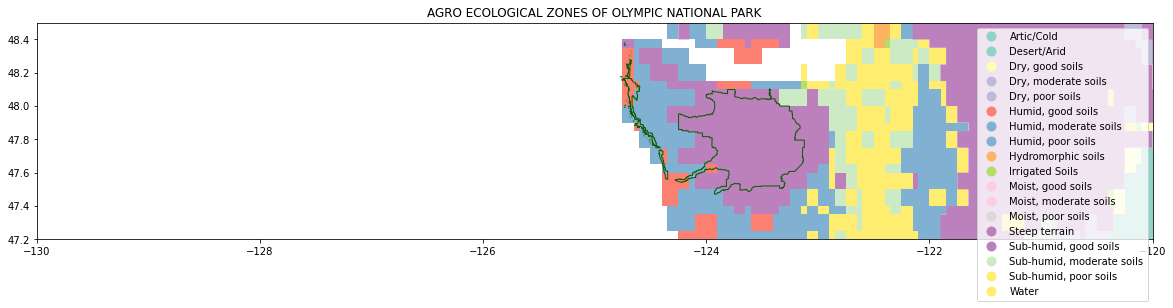

In [89]:
# visualize agro-ecological zones on the map
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('AGRO ECOLOGICAL ZONES OF OLYMPIC NATIONAL PARK')

set_map_limits(-130,47.2,-120,48.5)
# plot_countries(countries_boundaries_df,ax)
plot_features(agroeco_zones_df, ax=ax, column='value')
plot_park(park_df_original,ax,color = 'none')

plt.show()

Hence, Olympic national park largely has sub-humid, good soils.

#### Holdridge Life Zones in Olympic national park

In [78]:
# download holdridge life zones data
holdridge_zones_df = gpd.read_file("Holdridge/HoldridgeLifeZones.json")

In [79]:
# normalize column's name
holdridge_zones_df.rename(columns={'DESC': 'desc'}, inplace=True)

In [81]:
# get only necessary data related to park
holdridge_zones_df = holdridge_zones_df[['desc', 'geometry']]


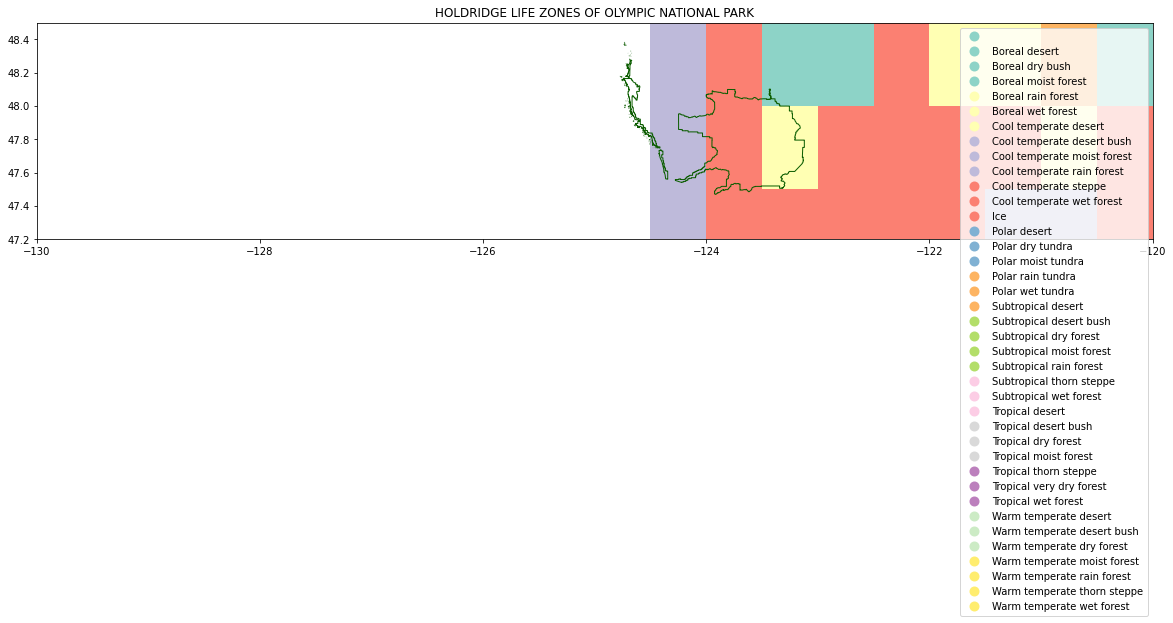

In [84]:
# visualize holdridge life zones on the map
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title('HOLDRIDGE LIFE ZONES OF OLYMPIC NATIONAL PARK')
set_map_limits(-130,47.2,-120,48.5)
# plot_countries(countries_boundaries_df,ax)
plot_features(holdridge_zones_df, ax=ax, column='desc')
plot_park(park_df_original,ax,color = 'none')

plt.show()

#### Soil Resources in Olympic national park

In [85]:
# download soil data
soil_df = gpd.read_file("Soil/World_Soil_Resources_wgs84.geojson")

In [86]:
# normalize column's name
soil_df.rename(columns={'IPCC': 'ipcc'}, inplace=True)

# get only necessary data related to park
soil_df = soil_df[['ipcc', 'geometry']]


#### Soil resources in Olympic national park

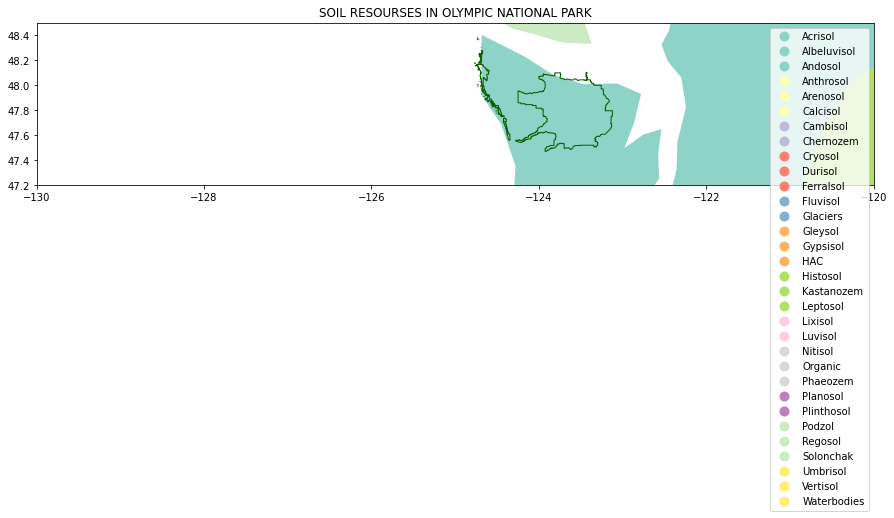

In [91]:
# visualize soil resources on the map
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title('SOIL RESOURSES IN OLYMPIC NATIONAL PARK')
set_map_limits(-130,47.2,-120,48.5)
# plot_countries(countries_boundaries_df,ax)
plot_features(soil_df, ax=ax, column='ipcc')
plot_park(park_df_original,ax,color = 'none')

plt.show()

Hence , Olympic national park has Albeluvisol soil

### Conclusion

Based on the findings in Olympic National Park:

Climate Zones : The cool temperate moist climate is the primary climate zone within Olympic National Park. This climate type is prevalent throughout the park, highlighting its role in shaping the local environment.

Terrestrial Ecoregions: The ecological landscape of Olympic National Park includes two terrestrial ecoregions. The Central Pacific Coastal Forest ecoregion has the most extensive coverage, underlining its role in influencing the park’s biodiversity and ecological dynamics. The Puget Lowland forest ecoregion also contributes significantly to the park’s ecological composition.

Ecological Zones: Olympic National Park consists of two ecological zones. The Temperature Mountain System is the largest ecological zone, demonstrating its dominance in the park’s interior regions. On the other hand, the Temperature Oceanic Forest covers a smaller area, indicating its existence in specific localized habitats within the park.

In conclusion, the findings highlight the widespread presence of the cool temperate moist climate, the importance of the Central Pacific Coastal Forest ecoregion, and the dominance of the Temperature Mountain System ecological zone within Olympic National Park. These elements collectively shape the park’s unique biodiversity and ecological features.